In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import IPython
import IPython.display
from ipywidgets import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import json
from tensorflow import keras
from keras import layers
from skimage.restoration import denoise_tv_chambolle

from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list

%matplotlib widget

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
N = 10
T = 32
total_range = T+200

In [3]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list).copy()

In [4]:
def radius_list(xs:np.ndarray, ys:np.ndarray):
    assert xs.ndim == 1 and ys.ndim == 1
    rad_list = [0.]
    disp_list = []
    for i in range(1, len(xs)):
        rad_list.append(np.sqrt((xs[i] - xs[0])**2 + (ys[i] - ys[0])**2))
        disp_list.append(np.sqrt((xs[i] - xs[i-1])**2 + (ys[i] - ys[i-1])**2))
    return np.array(rad_list) / np.mean(disp_list) / len(xs)

In [5]:
def shuffle(data, *args):
    shuffle_index = np.arange(data.shape[0])
    np.random.shuffle(shuffle_index)
    args = list(args)
    for i, arg in enumerate(args):
        args[i] = arg[shuffle_index]
    return data[shuffle_index], *args

In [6]:
input_data = []
input_label = []

for alpha in np.arange(0.001, 2, 0.001):
    D = np.random.uniform(low=0.01, high=10.0)
    #alpha = np.random.choice([0.01, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 1.99], 1)[0]
    trajs_model, labels_model = models_phenom().single_state(N=N,
                                                             L=None,
                                                             T=total_range,
                                                             alphas=alpha,
                                                             Ds=[D, 0],
                                                            )
    for n_traj in range(N):
        #var_length = np.random.randint(-4, 4)
        xs = trajs_model[:, n_traj, 0][:T]
        ys = trajs_model[:, n_traj, 1][:T]
        rad_list = radius_list(xs, ys)
        
        xs = xs / (np.std(xs))
        xs = np.cumsum(abs(uncumulate(xs))) / T
        ys = ys / (np.std(ys))
        ys = np.cumsum(abs(uncumulate(ys))) / T
        
        input_list = np.vstack((((xs + ys) /2), rad_list)).T
        input_data.append(input_list)
        input_label.append(alpha)
        
        for _ in range(25):
            #var_length = np.random.randint(-4, 4)
            random_start = np.random.randint(10, total_range-T)
            xs = trajs_model[:, n_traj, 0][random_start:random_start + T]
            ys = trajs_model[:, n_traj, 1][random_start:random_start + T]
            rad_list = radius_list(xs, ys)
            
            xs = xs / (np.std(xs))
            xs = np.cumsum(abs(uncumulate(xs))) / T
            ys = ys / (np.std(ys))
            ys = np.cumsum(abs(uncumulate(ys))) / T
                    
            input_list = np.vstack((((xs + ys) /2), rad_list)).T
            input_data.append(input_list)
            input_label.append(alpha)
            
input_data = np.array(input_data)
input_label = np.array(input_label)

In [7]:
valid_data = []
valid_label = []

for alpha in np.arange(0.001, 2, 0.001):
    D = np.random.uniform(low=0.01, high=10.0)
    #alpha = np.random.choice([0.01, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 1.99], 1)[0]
    trajs_model, labels_model = models_phenom().single_state(N=3,
                                                             L=None,
                                                             T=total_range,
                                                             alphas=alpha,
                                                             Ds=[D, 0],
                                                            )
    for n_traj in range(3):        
        for _ in range(25):
            random_start = np.random.randint(0, total_range-T)
            xs = trajs_model[:, n_traj, 0][random_start:random_start + T]
            ys = trajs_model[:, n_traj, 1][random_start:random_start + T]
            rad_list = radius_list(xs, ys)
            
            xs = xs / (np.std(xs))
            xs = np.cumsum(abs(uncumulate(xs))) / T
            ys = ys / (np.std(ys))
            ys = np.cumsum(abs(uncumulate(ys))) / T
                    
            input_list = np.vstack((((xs + ys) /2), rad_list)).T
            valid_data.append(input_list)
            valid_label.append(alpha)
            
valid_data = np.array(valid_data)
valid_label = np.array(valid_label)

In [8]:
train_input, train_label = shuffle(input_data, input_label)
val_input, val_label = shuffle(valid_data, valid_label)

(519740, 32, 2) (519740,)


(array([2340., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2860., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2340., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
      

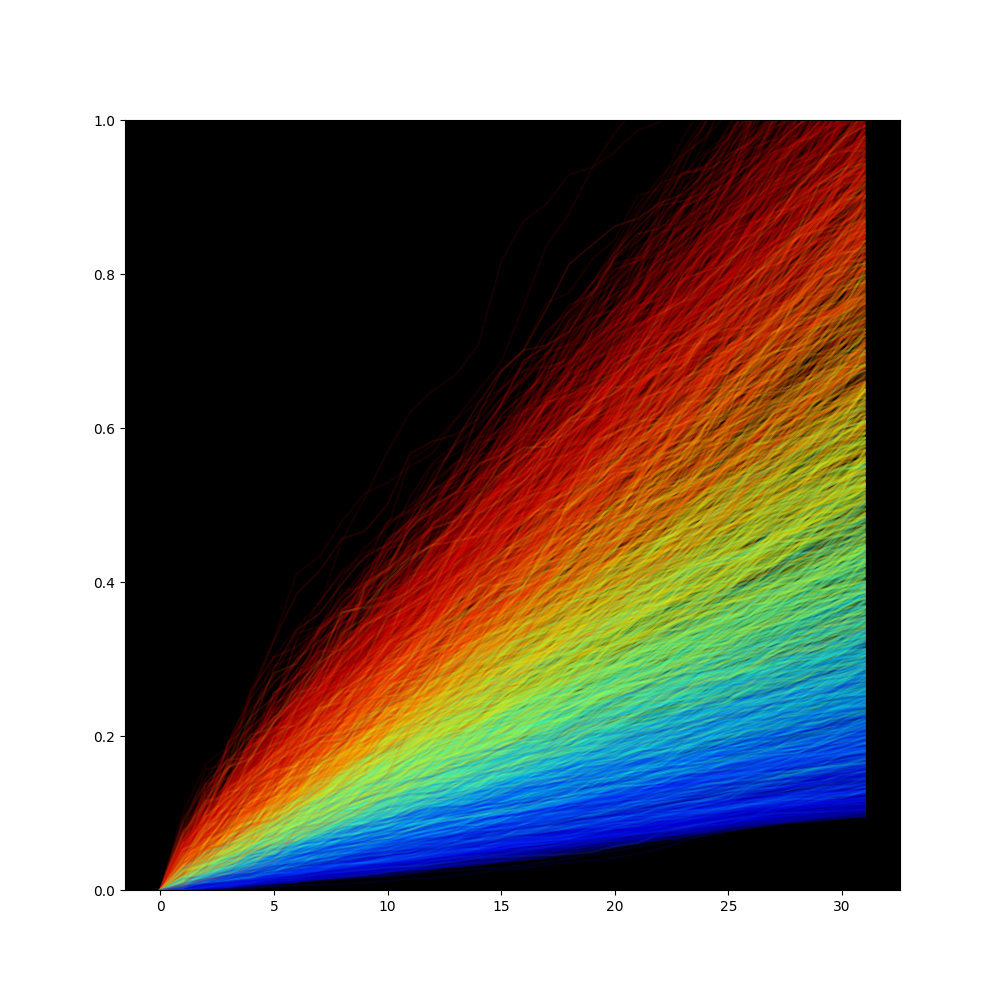

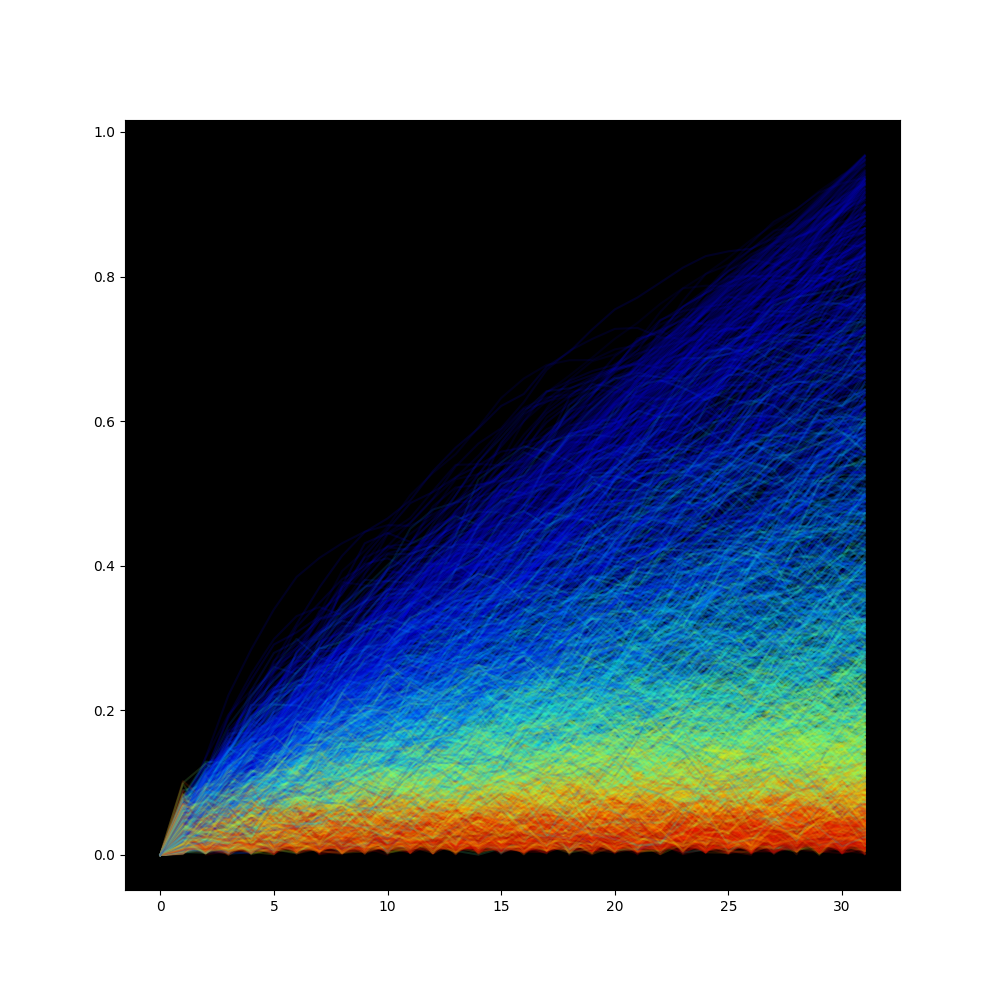

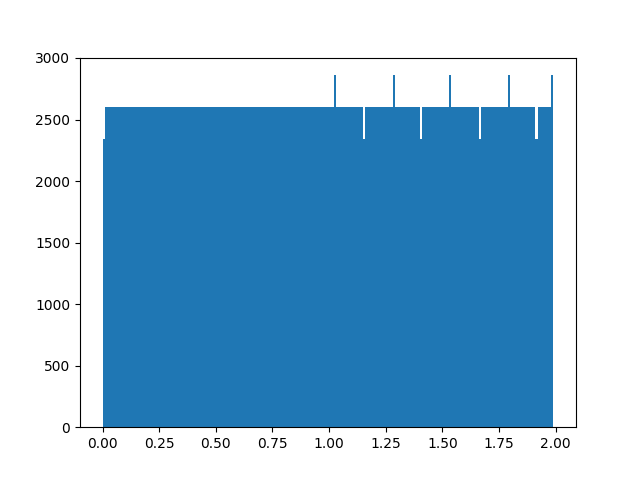

In [9]:
print(input_data.shape, input_label.shape)
colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_facecolor("black")
for i in range(0, 3000):
    color = color_seq[int(train_label[i]/2. * 255)]
    ax.plot(train_input[i, :, 0], color=color, alpha=0.15, zorder=-1)
ax.set_ylim([0, 1])

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_facecolor("black")
for i in range(0, 3000):
    color = color_seq[int(train_label[i]/2. * 255)]
    ax.plot(train_input[i, :, 1], color=color, alpha=0.15, zorder=-1)

plt.figure()
plt.hist(train_label, bins=np.arange(0, 2, 0.01))

In [10]:
train_input = train_input.reshape(-1, T, 1, 2)
train_label = train_label.reshape(-1, 1)
val_input = val_input.reshape(-1, T, 1, 2)
val_label = val_label.reshape(-1, 1)

In [11]:
print(f'train_reg_shape:{train_input.shape}\n',
      f'train_label_shape:{train_label.shape}\n'
      f'val_reg_shape:{val_input.shape}\n',
      f'val_label_shape:{val_label.shape}\n'
     )

train_reg_shape:(519740, 32, 1, 2)
 train_label_shape:(519740, 1)
val_reg_shape:(149925, 32, 1, 2)
 val_label_shape:(149925, 1)



In [19]:
# Shape [batch, time, features] => [batch, time, lstm_units]
reg_input = keras.Input(shape=(None, 1, 2), name="reg_signals")
x = layers.ConvLSTM1D(filters=128, kernel_size=2, strides=1,
                      padding='same', dropout=0.1, data_format="channels_last")(reg_input)
x = layers.ReLU()(x)
x = layers.Bidirectional(layers.LSTM(64, dropout=0.1))(x)
x = layers.ReLU()(x)
x = layers.Flatten()(x)
reg_dense = layers.Dense(units=64, activation='relu')(x)
reg_last_layer = layers.Dense(units=1)(reg_dense)

reg_model = keras.Model(
    inputs=[reg_input],
    outputs=[reg_last_layer],
    name='anomalous_regression'
)

In [20]:
reg_model.compile(loss=tf.keras.losses.MeanSquaredError(name='mean_squared_error'),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3/2),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(name='MAE'),
                          ]
                 )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=20,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True,
                                                  start_from_epoch=3
                                                 )

In [21]:
reg_history = reg_model.fit(x=train_input,
                            y=train_label,
                            validation_data=(val_input, val_label),
                            batch_size=1024,
                            epochs=1500,
                            shuffle=True,
                            callbacks=[early_stopping],
                            verbose=2
                           )
reg_model.save(f'./models/reg_model_{T}.keras')
history_dict = reg_history.history
json.dump(history_dict, open(f'./models/reg_history_{T}.json', 'w'))

Epoch 1/1500


2024-05-31 09:10:14.666037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-31 09:10:14.878837: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


KeyboardInterrupt: 

# Test

In [50]:
model_check = 32
test_N = 3
test_T = 200

In [51]:
regression_model = tf.keras.models.load_model(f'./models/alpha_reg_models/reg_model_{model_check}.keras')

In [8]:
test_data = []
test_label = []

for alpha in np.arange(0.001, 2, 0.001):
    D = np.random.uniform(low=0.01, high=10.0)
    trajs_model, labels_model = models_phenom().single_state(N=test_N,
                                                             L=None,
                                                             T=test_T,
                                                             alphas=alpha,
                                                             Ds=[D, 0],
                                                            )
    for n_traj in range(test_N):
        for _ in range(25):
            random_start = np.random.randint(0, test_T - model_check)
            xs = trajs_model[:, n_traj, 0][random_start:random_start + model_check]
            ys = trajs_model[:, n_traj, 1][random_start:random_start + model_check]
            rad_list = radius_list(xs, ys)
                
            xs = xs / (np.std(xs))
            xs = np.cumsum(abs(uncumulate(xs))) / len(xs)
            ys = ys / (np.std(ys))
            ys = np.cumsum(abs(uncumulate(ys))) / len(ys)
            test_data.append(np.vstack((((xs + ys) /2), rad_list)).T)
            test_label.append(alpha)

In [9]:
test_data = np.array(test_data).reshape(-1, model_check, 1, 2)
test_label = np.array(test_label).reshape(-1, 1)

In [11]:
pred = regression_model.predict(test_data)
print(f'MAE_valid: {np.mean(abs(pred - test_label))}')
grid = np.arange(-0.3, 2.3, 0.1)
H, xedges, yedges = np.histogram2d(test_label.flatten(), pred.flatten(), bins=(grid, grid), density=True)
print(np.hstack((test_label[:50], pred[:50])))

2024-06-01 00:07:52.421104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4686/4686 [==============================] - 1017s 217ms/step
MAE_valid: 0.1043874587612426
[[0.001      0.12279452]
 [0.001      0.12341325]
 [0.001      0.16129664]
 [0.001      0.14850923]
 [0.001      0.12168598]
 [0.001      0.13311405]
 [0.001      0.15017414]
 [0.001      0.11282818]
 [0.001      0.13715643]
 [0.001      0.15765199]
 [0.001      0.10615729]
 [0.001      0.16715045]
 [0.001      0.15017414]
 [0.001      0.08441097]
 [0.001      0.10396121]
 [0.001      0.09195948]
 [0.001      0.09495299]
 [0.001      0.13687988]
 [0.001      0.1253439 ]
 [0.001      0.15408573]
 [0.001      0.07217053]
 [0.001      0.13087851]
 [0.001      0.08839674]
 [0.001      0.11084098]
 [0.001      0.10909715]
 [0.001      0.08037181]
 [0.001      0.07777661]
 [0.001      0.07272635]
 [0.001      0.06934779]
 [0.001      0.07894683]
 [0.001      0.13330396]
 [0.001      0.06468304]
 [0.001      0.07747956]
 [0.001      0.07515097]
 [0.001      0.07537504]
 [0.001      0.07282132]
 [0.001 

(array([675., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 825., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 675., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 825., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 675., 750., 750.,
        750., 750., 750., 750., 750., 

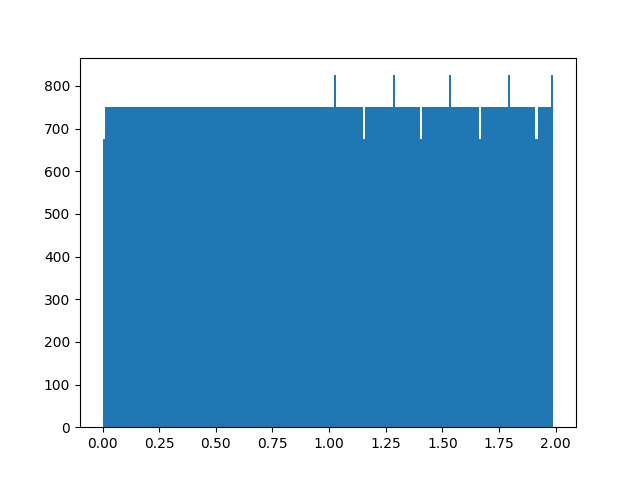

In [12]:
plt.figure()
plt.hist(test_label, bins=np.arange(0, 2, 0.01))

[Text(0.5, 80.7222222222222, 'Pred alpha'),
 Text(120.72222222222221, 0.5, 'True alpha')]

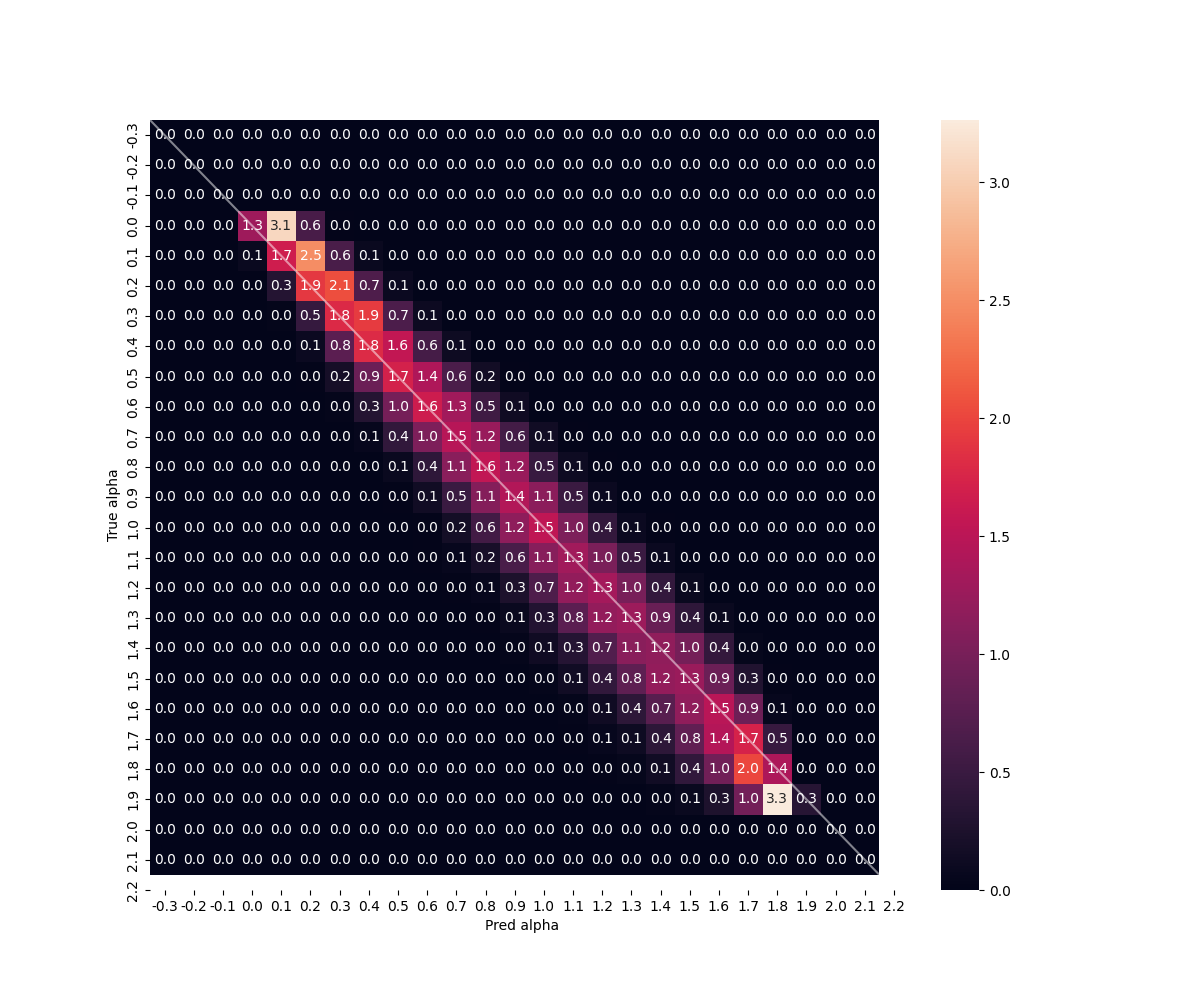

In [13]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(H, xticklabels=np.round(xedges, 1), yticklabels=np.round(yedges, 1), annot=True, fmt="3.1f")
ax.plot([0, 255],[0, 255], c='white', alpha=0.5, *ax.get_xlim())
ax.set(xlabel='Pred alpha', ylabel='True alpha')

In [ ]:
alpha_range = np.arange(0.001, 2, 0.1)
mae_mean = []
mae_ = []
for alpha in alpha_range:
    test_data = []
    test_label = []

    D = np.random.uniform(low=0.01, high=10.0)
    trajs_model, labels_model = models_phenom().single_state(N=100,
                                                             L=None,
                                                             T=test_T,
                                                             alphas=alpha,
                                                             Ds=[D, 0],
                                                            )
    for n_traj in range(100):
        for _ in range(25):
            random_start = np.random.randint(0, test_T - model_check)
            xs = trajs_model[:, n_traj, 0][random_start:random_start + model_check]
            ys = trajs_model[:, n_traj, 1][random_start:random_start + model_check]
            rad_list = radius_list(xs, ys)
                
            xs = xs / (np.std(xs))
            xs = np.cumsum(abs(uncumulate(xs))) / len(xs)
            ys = ys / (np.std(ys))
            ys = np.cumsum(abs(uncumulate(ys))) / len(ys)
            test_data.append(np.vstack((((xs + ys) /2), rad_list)).T)
            test_label.append(alpha)
    test_data = np.array(test_data).reshape(-1, model_check, 1, 2)
    test_label = np.array(test_label).reshape(-1, 1)
    pred = regression_model.predict(test_data)
    mae_mean.append(np.mean(abs(pred - test_label)))
    mae_.append(pred - test_label)

 3/79 [>.............................] - ETA: 5s

In [ ]:
mae_ = np.array(mae_).reshape(20, -1)
print(np.mean(mae_mean))
plt.figure()
plt.plot(alpha_range, mae_mean)
plt.ylim([0, 0.5])

plt.figure()
plt.plot((mae_).mean(axis=1))
plt.plot((mae_).std(axis=1))